In [2]:
import pandas as pd
import datetime as dt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import numpy as np
from uszipcode import SearchEngine
%matplotlib inline

In [3]:
df = pd.read_csv("data/assessments.csv",low_memory=False)

In [4]:
pd.set_option('display.max_rows', 200)

In [5]:
#drop if everything is nan
#drop target contains nan and important features that contain nan
df = df.dropna(how='all')
df = df.dropna(subset=['SALEPRICE', 'SALEDATE','PROPERTYCITY','PROPERTYZIP'])
df['SALEDATE'] = df['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))

(-36209.0, 19131.0)

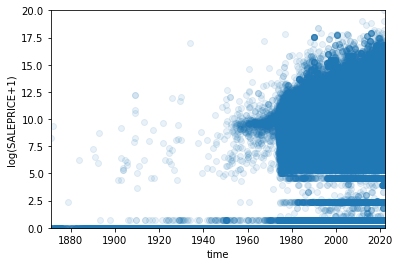

In [8]:
plt.xlabel('time')
plt.ylabel('log(SALEPRICE+1)')
plt.scatter(df['SALEDATE'],np.log(df['SALEPRICE']+1), alpha = 0.1)
plt.ylim([0, 20])
plt.xlim([df1['SALEDATE'].min(), df1['SALEDATE'].max()])

In [6]:
#remove all the sale price close to 0
df1 = df[df.SALEPRICE>10].copy().reset_index(drop=True)

(-36209.0, 19131.0)

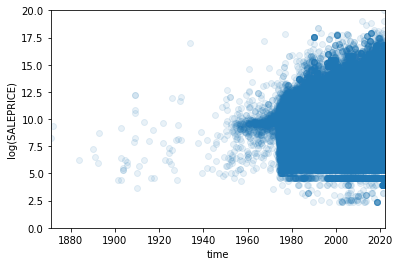

In [7]:
plt.xlabel('time')
plt.ylabel('log(SALEPRICE)')
plt.scatter(df1['SALEDATE'],np.log(df1['SALEPRICE']), alpha = 0.1)
plt.ylim([0, 20])
plt.xlim([df1['SALEDATE'].min(), df1['SALEDATE'].max()])

In [9]:
# remove outliers based on lower and upper limit
df_time = df1[['SALEDATE', 'SALEPRICE']].copy()
df_time['log_price'] = np.log(df_time['SALEPRICE'])

data_mean, data_std = df_time.log_price.mean(), df_time.log_price.std()
print("The mean is {}.".format(data_mean), "The std is {}.".format(data_std))
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print("The lower limit is {}.".format(lower), "The upper limit is {}.".format(upper))
df_time = df_time[(df_time['log_price']>lower)&(df_time['log_price']<upper)].reset_index(drop=True)
df_time = df_time.sort_values("SALEDATE").set_index('SALEDATE',drop=True)
df_time

The mean is 11.26715129266564. The std is 1.4873306851955648.
The lower limit is 6.805159237078945. The upper limit is 15.729143348252334.


,SALEPRICE,log_price
SALEDATE,,
1870-11-12,4000.0,8.294050
1871-11-07,12000.0,9.392662
1890-02-05,1350.0,7.207860
1892-11-30,6160.0,8.725832
1902-10-18,10000.0,9.210340
...,...,...
2022-05-17,5000.0,8.517193
2022-05-17,299900.0,12.611204
2022-05-18,132000.0,11.790557


In [10]:
#groupby saleprice to month and get the average
df_month = df_time.groupby(pd.Grouper(freq='1M')).mean()
df_month

,SALEPRICE,log_price
SALEDATE,,
1870-11-30,4000.000000,8.294050
1870-12-31,NaN,NaN
1871-01-31,NaN,NaN
1871-02-28,NaN,NaN
1871-03-31,NaN,NaN
...,...,...
2022-01-31,247463.119714,11.977693
2022-02-28,237028.453462,11.932236
2022-03-31,263703.250365,12.026390


<AxesSubplot:xlabel='SALEDATE'>

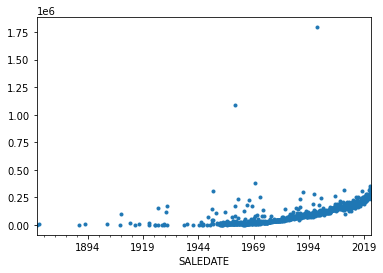

In [11]:
df_month.SALEPRICE.plot(ls='',marker='.')

<AxesSubplot:xlabel='SALEDATE'>

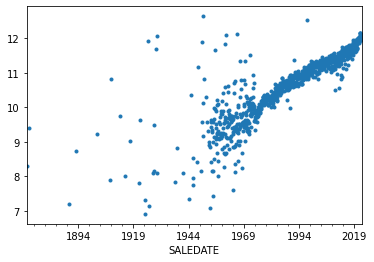

In [12]:
df_month.log_price.plot(ls='',marker='.')

In [13]:
#prepare dataset for Linear Regression
df_month = df_month.reset_index()
df_month['Timestamp'] = df_month['SALEDATE'].apply(lambda x: x.timestamp())
df_month = df_month.dropna()
df_month

,SALEDATE,SALEPRICE,log_price,Timestamp
0,1870-11-30,4000.000000,8.294050,-3.126902e+09
12,1871-11-30,12000.000000,9.392662,-3.095366e+09
231,1890-02-28,1350.000000,7.207860,-2.519510e+09
264,1892-11-30,6160.000000,8.725832,-2.432592e+09
383,1902-10-31,10000.000000,9.210340,-2.119738e+09
...,...,...,...,...
1814,2022-01-31,247463.119714,11.977693,1.643587e+09
1815,2022-02-28,237028.453462,11.932236,1.646006e+09
1816,2022-03-31,263703.250365,12.026390,1.648685e+09
1817,2022-04-30,264225.487404,12.052970,1.651277e+09


In [14]:
from sklearn.linear_model import LinearRegression

Text(0, 0.5, 'log(SALEPRICE)')

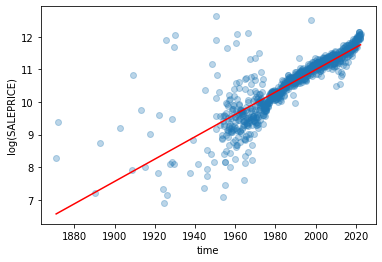

In [15]:
model = LinearRegression()
model.fit(df_month[['Timestamp']], df_month[['log_price']])
y_pred = model.predict(df_month[['Timestamp']])
plt.plot(df_month.SALEDATE, y_pred, color='r')
plt.scatter(df_month.SALEDATE, df_month.log_price, alpha = 0.3)
plt.xlabel('time')
plt.ylabel('log(SALEPRICE)')

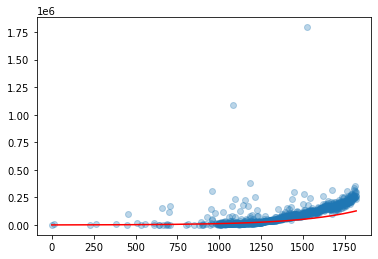

In [16]:
plt.plot(df_month.index, np.exp(y_pred), color='r')
plt.scatter(df_month.index, df_month.SALEPRICE, alpha = 0.3)

In [17]:
# housing price is not martingale!